In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import math
from collections import defaultdict
from matplotlib import pyplot as plt

Please download the image 'input.png' from the given link (https://drive.google.com/file/d/1oQSxTCFiJ2yI7LsmQE3grrYKAdKWPj6Q/view?usp=share_link) and upload it to the current directory of this colab session.

In [ ]:
original = cv2.imread('./input.png')
image = original.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

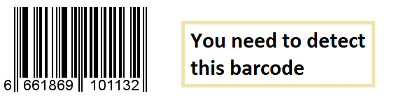

In [ ]:
cv2_imshow(cv2.resize(original,None, fx=0.7, fy=0.7, interpolation = cv2.INTER_CUBIC))

In [ ]:
image = cv2.resize(image,None,fx=0.7, fy=0.7, interpolation = cv2.INTER_CUBIC)
original = cv2.resize(original,None,fx=0.7, fy=0.7, interpolation = cv2.INTER_CUBIC)

In [ ]:
gradX = cv2.Sobel(image, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
gradY = cv2.Sobel(image, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)

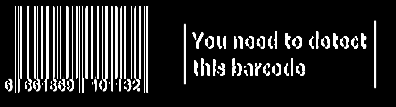

In [ ]:
cv2_imshow(cv2.resize(gradX,None, fx=1, fy=1, interpolation = cv2.INTER_CUBIC))

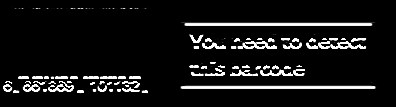

In [ ]:
cv2_imshow(cv2.resize(gradY,None, fx=1, fy=1, interpolation = cv2.INTER_CUBIC))

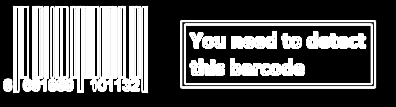

In [ ]:
gradient = cv2.sqrt(cv2.add(gradX*gradX, gradY*gradY))
gradient = cv2.convertScaleAbs(gradient)  #converts the gradient image to an 8-bit representation.
cv2_imshow(cv2.resize(gradient,None, fx=1, fy=1, interpolation = cv2.INTER_CUBIC))

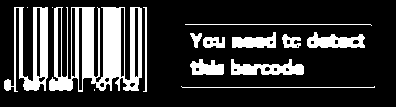

In [ ]:
blurred = cv2.blur(gradient, (3, 3))
(_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

cv2_imshow(cv2.resize(thresh,None, fx=1, fy=1, interpolation = cv2.INTER_CUBIC))

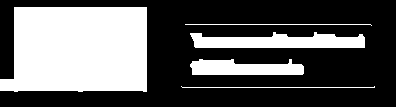

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

cv2_imshow(cv2.resize(closed,None, fx=1, fy=1, interpolation = cv2.INTER_CUBIC))

closed = cv2.dilate(closed, None, iterations = 7)
cnts,hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

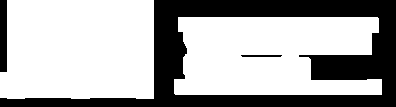

In [ ]:
cv2_imshow(cv2.resize(closed,None, fx=1, fy=1, interpolation = cv2.INTER_CUBIC))

In [ ]:
rect = cv2.minAreaRect(c)
box = np.int0(cv2.boxPoints(rect))

img = original.copy()

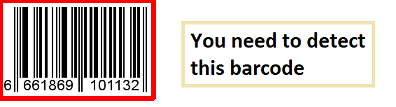

In [ ]:
cv2.drawContours(img, [box], -1, (0, 0, 255), 3)
cv2_imshow(img)

In [ ]:
def getSubImage(rect, src):
    center, size, theta = rect 
    size = [size[1],size[0]]
    center, size = tuple(map(int, center)), tuple(map(int, size))
    M = cv2.getRotationMatrix2D( center, theta-90, 1)
    print(src.shape)
    dst = cv2.warpAffine(src, M, [src.shape[1],src.shape[0]])
    out = cv2.getRectSubPix(dst, size, center)
    return out

(107, 396)


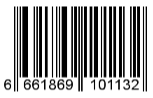

In [ ]:
out = getSubImage(rect, image)
cv2_imshow(out)

In [ ]:
out = out.astype('uint8')
out = cv2.cvtColor(out,cv2.COLOR_GRAY2RGB)

In [ ]:
encoding_pattern ={
        "111111":0,
        "110100":1,
        "110010":2,
        "110001":3,
        "101100":4,
        "100110":5,
        "100011":6,
        "101010":7,
        "101001":8,
        "100101":9
}
left=[
    {
        "0100111":0,
        "0110011":1,
        "0011011":2,
        "0100001":3,
        "0011101":4,
        "0111001":5,
        "0000101":6,
        "0010001":7,
        "0001001":8,
        "0010111":9   
    },
    {
        "0001101":0,
        "0011001":1,
        "0010011":2,
        "0111101":3,
        "0100011":4,
        "0110001":5,
        "0101111":6,
        "0111011":7,
        "0110111":8,
        "0001011":9   
    }
]
right = {
        "1110010":0,
        "1100110":1,
        "1101100":2,
        "1000010":3,
        "1011100":4,
        "1001110":5,
        "1010000":6,
        "1000100":7,
        "1001000":8,
        "1110100":9 
}

In [ ]:
# def binarise(pic, thrs):
#   img = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
#   ret, threshimg = cv2.threshold(img, thrs, 255, cv2.THRESH_BINARY)
#   return threshimg

def rgb2gray(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

def thresholding(img, thrs):
  return np.where(img < thrs , 0, 255)

def binarise(pic, thrs):
  img = rgb2gray(pic)
  threshimg = thresholding(img, thrs)
  return threshimg

In [ ]:
def primitive_crop(row):
    indices = np.where(row == 0)[0]
    if indices.shape[0] == 0:
      return None
    return row[indices[0]:indices[-1]+1]

In [ ]:
def convert_binary(bars,nlb):
    binstring = ''
    d = 1
    cnt = 0
    np.append(bars,[-1])
    for i in bars:
      if i == (255 - d*255):
        cnt = cnt + 1
      else:
        if d == 1:
          d = 0
          binstring = binstring + '1'*math.ceil(cnt/nlb)
        else:
          d = 1
          binstring = binstring + '0'*math.floor(cnt/nlb)
        cnt = 1
    return binstring

In [ ]:
def find_num_bars(cropped_row):
    num = 0
    for i in cropped_row:
        if i == 255:
            break
        else:
            num += 1
    return num

In [ ]:
def find_encoding(bs_list):
    par_str = ""
    for number in range(6):
        parity = 0
        for i in bs_list[number]:
            parity ^= int(i)
        par_str += str(parity)
    return par_str

In [ ]:
def get_digits(binary_string,rep_length):
    number_strings = []
    start_pos = 3
    end_pos = len(binary_string) - 3
    i = start_pos
    while(i < end_pos):
        if i == start_pos + rep_length*6:
            i+=5
            continue
        number_strings.append(str(binary_string[i:i+rep_length]))
        i += rep_length
    return number_strings

In [ ]:
def decode(encoding_patter_number,bs_list):
    info = ""
    info += str(encoding_pattern[encoding_pattern_number]) + '-'
    for i in range(6):
        # print(info)
        info += str(left[int(encoding_pattern_number[i])][bs_list[i]])
    info += '-'
    for i in range(6,12):
        info += str(right[bs_list[i]])
    return info

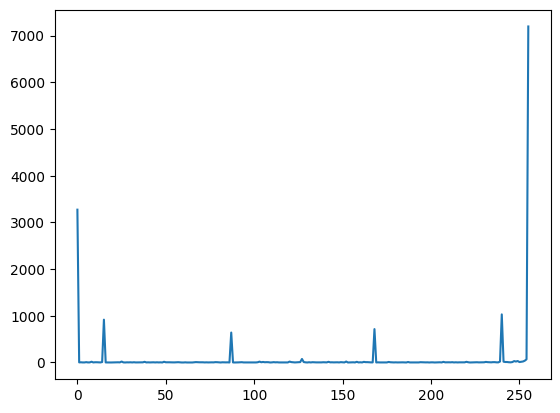

In [ ]:
histr = cv2.calcHist([out],[0],None,[256],[0,256])
plt.plot(histr)

In [ ]:
image_cropped = out
image_cropped = cv2.resize(image_cropped, (219, 100))

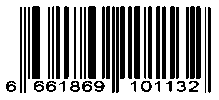

In [ ]:
bimg = binarise(image_cropped,150)
cv2_imshow(bimg)

In [ ]:
ctr = defaultdict(int)
for row in bimg:
  cropped_row = primitive_crop(row)
  if cropped_row is None:
    continue
  try:
    nlb = find_num_bars(cropped_row)
    binary_string = convert_binary(cropped_row,nlb)
    rep_length = 7
    num_numbers = 13
    bs_list = get_digits(binary_string,rep_length)
    encoding_pattern_number = find_encoding(bs_list)
    information = decode(encoding_pattern_number,bs_list)
    ctr[information] +=1
  except:
    continue

if len(list(ctr.keys())):
  print('Decoded Barcode:',list(ctr.keys())[0])
else:
  print('Barcode Detection Failed!!!')

Decoded Barcode: 6-661869-101132
